In [1]:
import cmdtools
from cmdtools.estimation.sqra import SQRA
import numpy as np, matplotlib.pyplot as plt

# 1. Generator estimation via SQRA

The square root approximation allows us to estimate the generator for an arbitrarily given potential function:

In [2]:
xs = np.linspace(-1.4, 1.4, 20)
u  = (xs**2-1)**2

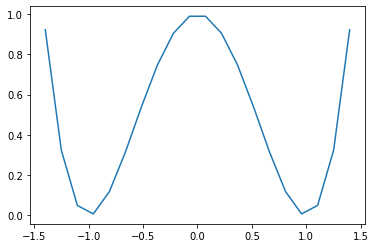

In [3]:
plt.plot(xs,u)

In [4]:
s = cmdtools.estimation.sqra.SQRA(u, beta=3, phi=10) # beta is the inverse temperature of the system, phi a linear scaling factor depending on discretization
Q = s.Q.toarray() # convert sparse to dense for plotting

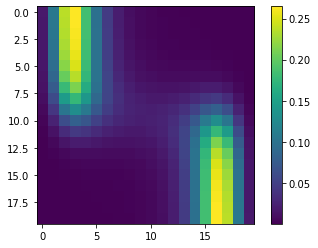

In [5]:
# plot the transfer operator
from scipy.linalg import expm
plt.imshow(expm(Q))
plt.colorbar()

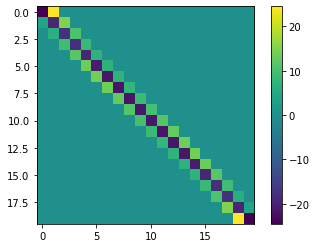

In [6]:
plt.imshow(Q)
plt.colorbar()

We intend to provide a collection of toy systems. Suggestions for there are very welcome.

The following line constructs the potential for a triple well and implicitly computes its generator via the SQRA.

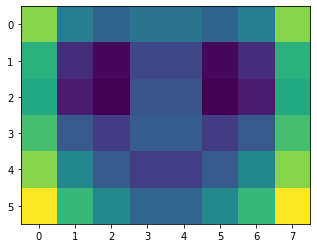

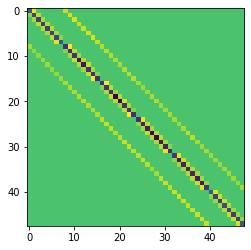

In [7]:
triplewell = cmdtools.systems.diffusion.TripleWell(nx=8,ny=6)
plt.imshow(triplewell.u)
plt.figure()
plt.imshow(triplewell.Q.toarray())

CPU times: user 312 ms, sys: 0 ns, total: 312 ms
Wall time: 310 ms


<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49600 stored elements in Compressed Sparse Column format>

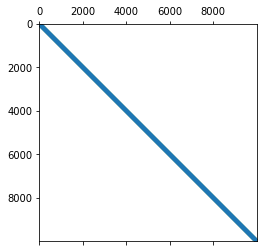

In [8]:
# Note that the generator estimation is fairly fast even for moderate sized systems (eg. this sparse 10000x10000 matrix)
%time bigsystem = cmdtools.systems.diffusion.TripleWell(nx=100,ny=100)
plt.spy(bigsystem.Q, markersize=0.1)
bigsystem.Q

# 2. Time-dependent processes

In [9]:
ts = [0,1,2,3,4]
us = [u + 1/2 * xs * t for t in ts]

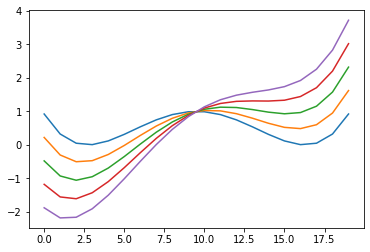

In [10]:
for ut in us:
    plt.plot(ut)

In [11]:
qs = [SQRA(u, beta = 5).Q for u in us] # array with the generators
dts = np.ones(len(ts)) # and time interval lengths that each generator is active

In [12]:
ajc = cmdtools.estimation.ajc.AJC(qs, dts) # construct the augmented jump chain

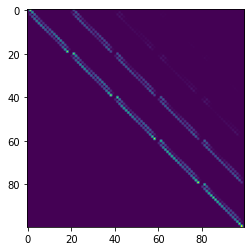

In [13]:
plt.imshow(ajc.km.todense()) # ajc.km contains the transition kernel matrix

By solving linear systems similar to the committor equations 
$$Kc = c \text{ in } A\cup B \\c = 1_A \text{ on } \delta(A \cup B)$$
we can solve for space-time committors.

For example, by setting the boundary to be the last timeframe $t \in [1,2]$ and imposing the boundary value to 1 at a specific space stell and 0 elsewhere, we solve for the probability to hit that state in the last timeframe, which corresponds to the application of the Koopman operator to the indicator function.

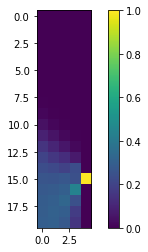

In [14]:
# Solving for c=Ind(15) on the last timeframe gives the probability to hit state 15 at the last time
plt.imshow(ajc.koopman_system_one(15).T)
plt.colorbar()

Solving this system for all states we can reconstruct the original Koopman operator.

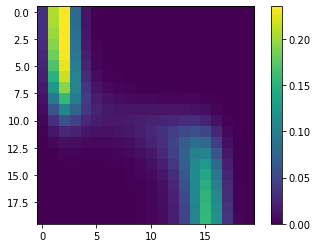

In [15]:
plt.imshow(ajc.koopman())
plt.colorbar()

Alternatively we can e.g solve for a finite time hitting probabilty, i.e. the time to hit a specific state inside some time interaval.
Here the solve for $c \equiv 1$ on the desired state.

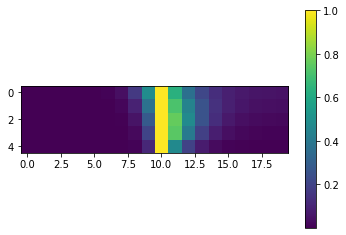

In [16]:
g = np.zeros(np.shape(us))
g.fill(np.nan) # set domain to be solved in to nan
g[:,10] = 1 # probability to hit state 10

fhp = ajc.space_time_committor(g)

plt.imshow(fhp)
plt.colorbar()